 Importing data and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import LSTM, SpatialDropout1D, Activation, GlobalAveragePooling1D, Dense, Input, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import ConfusionMatrixDisplay
import random
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ethan/opt/anaconda3/lib/python3.7/sit

In [2]:
import keras
keras.__version__

'2.3.1'

In [18]:
# Load dataset
def load_data():
  data=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_hs.csv')
  data=data.drop('Unnamed: 0', axis=1)
  return data

In [19]:
print(os.getcwd())

/Users/ethan/py3tf


In [20]:
label={0:'hate_speech', 1:'offensive_language', 2:'neither'}

In [21]:
# Plot data by target class
def plot(data):
  sns.countplot(data['class'])
  plt.xlabel('Class')
  plt.title('Distribution of data in each class')
  plt.ylabel('Count')
  plt.show()

### Creating EDA functions

In [22]:
data = load_data()
data.head()
print(len(data))

16852


In [13]:
count = data['tweet'].str.split().apply(len).value_counts()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
count

0 words:       1
1 words:     123
10 words:    927
11 words:    909
12 words:    809
13 words:    782
14 words:    721
15 words:    660
16 words:    644
17 words:    642
18 words:    609
19 words:    556
2 words:     314
20 words:    514
21 words:    460
22 words:    508
23 words:    435
24 words:    392
25 words:    349
26 words:    259
27 words:    212
28 words:    131
29 words:     96
3 words:     467
30 words:     65
31 words:     38
32 words:     13
33 words:      4
34 words:      1
4 words:     689
5 words:     815
6 words:     912
7 words:     923
8 words:     938
9 words:     934
Name: tweet, dtype: int64

In [ ]:
df['totalwords'] = [len(x.split()) for x in df['col'].tolist()]

,class,tweet
0,0,I hate when faggots talk shit on here then b...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m a joke having hoes ain t shit I m just...
4,2,It s not as easy as you d think to find an a...
...,...,...
16847,2,I need to pick between two wigs The agony ...
16848,0,I feel like Tim Ross is a nigger
16849,0,Horrible rapper Tyga Most trash rapper ...
16850,1,Contrary to belief us queers don t go...


In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /Users/ethan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ethan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ethan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			# print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)
 

In [10]:
def random_deletion(words, p):

	#if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words


In [11]:
def random_swap(words, n):
  sent = ""
  new_words = words.copy()
  for _ in range(n):
    new_words = swap_word(new_words)
  return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words


In [12]:
def random_addition(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



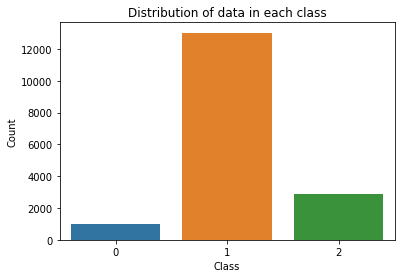

In [13]:
plot(data)

# Augment dataset with EDA Techniques

### SR

In [14]:
n = 9
data_sr = data.copy(deep=True)
for m,i in enumerate(data['tweet']):
  i = i.replace('  ', '')
  j = nltk.word_tokenize(i)
  data_sr['tweet'][m] = ' '.join(synonym_replacement(j, n))

data_sr.head()

,class,tweet
0,0,single hatred when fairy speak turd on here th...
1,1,dull grouse
2,1,net ball criminal record a call gripe veraciou...
3,1,single m a antic having hoe ain t shitI m just...
4,2,information technology s not as soft as you d ...


0        0
1        1
2        1
3        1
4        2
        ..
16847    2
16848    0
16849    0
16850    1
16851    0
Name: class, Length: 16852, dtype: int64


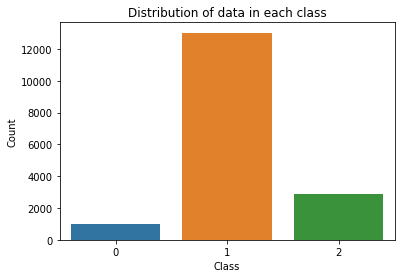

In [15]:
print(data_sr['class'])
plot(data_sr)

### RD

In [16]:
p = 0.2
data_rd = data.copy(deep=True)
for i,tweet in enumerate(data['tweet']):
  tweet = tweet.replace('  ', '')
  j = nltk.word_tokenize(tweet)
  if len(j) < 2:
    continue
  data_rd['tweet'][i] = ' '.join(random_deletion(j, p))
data_rd.head()

,class,tweet
0,0,I hate when faggots talk shit then block me so...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m having hoes ain t shitI for the first girl...
4,2,It s not easy as you d think to find an astron...


### RS

In [17]:
n = 9
data_rs = data.copy(deep=True)
for i, tweet in enumerate(data['tweet']):
  tweet = tweet.replace('  ', '')
  j = nltk.word_tokenize(tweet)
  if len(j) < 2:
    continue
  data_rs['tweet'][i] = ' '.join(random_swap(j, n))
data_rs.head()

,class,tweet
0,0,I on talk faggots when can I here then block m...
1,1,Dumb bitch
2,1,lets bitch a song nowb record right
3,1,I shitI in girl just hoes ain m a having I loo...
4,2,monkey to not It find as you as minute last ea...


### RI

In [18]:
n = 9
data_ra = data.copy(deep=True)
for i, tweet in enumerate(data['tweet']):
  tweet = tweet.replace('  ', '')
  j = nltk.word_tokenize(tweet)
  if len(j) < 2:
    continue
  data_ra['tweet'][i] = ' '.join(random_addition(j, n))
data_ra.head()

,class,tweet
0,0,I hate when faggots talk shit angstrom on and...
1,1,tongueless mute tongueless mute grouse bitch g...
2,1,permit right wing tolerate lets vocal music re...
3,1,I m a joke fair having hoes ain t fair due sou...
4,2,It s non not as easy as you easily d call up e...


## Augmenting hate class

In [22]:
data_hate = data.loc[data['class'] == 0]

In [6]:
def load_aug_data():
  daug_sr=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_hs_sr.csv')
  daug_rs=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_hs_rs.csv')
  daug_rd=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_hs_rd.csv')
  daug_ri=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_hs_ri.csv')
  daug_sr=daug_sr.drop('Unnamed: 0', axis=1)
  daug_rs=daug_rs.drop('Unnamed: 0', axis=1)
  daug_rd=daug_rd.drop('Unnamed: 0', axis=1)
  daug_ri=daug_ri.drop('Unnamed: 0', axis=1)
  return daug_sr, daug_rs, daug_rd, daug_ri

In [7]:
daug_sr, daug_rs, daug_rd, daug_ri = load_aug_data()

In [8]:
daug_sr

,class,tweet
0,0,I hate when faggots talk shit on here then b...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m a joke having hoes ain t shit I m just...
4,2,It s not as easy as you d think to find an a...
...,...,...
33699,2,iodin motive to plectron between deuce wigsThe...
33700,0,atomic number finger ilk Tim nellie ross is a...
33701,0,ugly rapperTyga Most crank doorknocker everShe...
33702,1,contrary to beliefus queer don t hug drug roun...


In [ ]:
df.loc[df['column_name'] != some_value]

In [9]:
def append_aug_data():
    daug_sr_a = daug_sr[daug_sr.index > 16851]
    daug_rs_a = daug_rs[daug_rs.index > 16851]
    daug_rd_a = daug_rd[daug_rd.index > 16851]
    daug_ri_a = daug_ri[daug_ri.index > 16851]
    dhate_sr = daug_sr_a[daug_sr_a['class'] != 1]
    dhate_rs = daug_rs_a[daug_rs_a['class'] != 1]
    dhate_rd = daug_rd_a[daug_rd_a['class'] != 1]
    dhate_ri = daug_ri_a[daug_ri_a['class'] != 1]
    return dhate_sr, dhate_rs, dhate_rd, dhate_ri

In [10]:
dhate_sr, dhate_rs, dhate_rd, dhate_ri = append_aug_data()

In [17]:
dhate_sr.loc[dhate_sr['class'] == 1]

,class,tweet


In [23]:
train_hate_sr = pd.concat([data, dhate_sr], ignore_index=True, sort=False)
train_hate_rs = pd.concat([data, dhate_rs], ignore_index=True, sort=False)
train_hate_rd = pd.concat([data, dhate_rd], ignore_index=True, sort=False)
train_hate_ri = pd.concat([data, dhate_ri], ignore_index=True, sort=False)

In [24]:
# train_hate_sr = train_hate_sr.sample(frac=1).reset_index(drop=True)
# train_hate_rs = train_hate_rs.sample(frac=1).reset_index(drop=True)
# train_hate_rd = train_hate_rd.sample(frac=1).reset_index(drop=True)
# train_hate_ri = train_hate_ri.sample(frac=1).reset_index(drop=True)

In [25]:
train_hate_sr

,class,tweet
0,0,I hate when faggots talk shit on here then b...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m a joke having hoes ain t shit I m just...
4,2,It s not as easy as you d think to find an a...
...,...,...
20679,0,lmaoo what a poof
20680,2,iodin motive to plectron between deuce wigsThe...
20681,0,atomic number finger ilk Tim nellie ross is a...
20682,0,ugly rapperTyga Most crank doorknocker everShe...


In [26]:
train_hate_sr.to_csv('train_partial_sr.csv')
train_hate_rs.to_csv('train_partial_rs.csv')
train_hate_rd.to_csv('train_partial_rd.csv')
train_hate_ri.to_csv('train_partial_ri.csv')

In [30]:
train_hate_sr_rs = pd.concat([train_hate_sr, dhate_rs], ignore_index=True, sort=False)
train_hate_sr_rd = pd.concat([train_hate_sr, dhate_rd], ignore_index=True, sort=False)
train_hate_sr_ri = pd.concat([train_hate_sr, dhate_ri], ignore_index=True, sort=False)
train_hate_rs_rd = pd.concat([train_hate_rs, dhate_rd], ignore_index=True, sort=False)
train_hate_rs_ri = pd.concat([train_hate_rs, dhate_ri], ignore_index=True, sort=False)
train_hate_rd_ri = pd.concat([train_hate_rd, dhate_ri], ignore_index=True, sort=False)

In [31]:
# train_hate_sr_rs = train_hate_sr_rs.sample(frac=1).reset_index(drop=True)
# train_hate_sr_rd = train_hate_sr_rd.sample(frac=1).reset_index(drop=True)
# train_hate_sr_ri = train_hate_sr_ri.sample(frac=1).reset_index(drop=True)
# train_hate_rs_rd = train_hate_rs_rd.sample(frac=1).reset_index(drop=True)
# train_hate_rs_ri = train_hate_rs_ri.sample(frac=1).reset_index(drop=True)
# train_hate_rd_ri = train_hate_rd_ri.sample(frac=1).reset_index(drop=True)

In [32]:
train_hate_sr_rs

,class,tweet
0,0,I hate when faggots talk shit on here then b...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m a joke having hoes ain t shit I m just...
4,2,It s not as easy as you d think to find an a...
...,...,...
24511,0,lmaoo what fag a
24512,2,multi bob to colored my cute red agony My two ...
24513,0,I a is Ross nigger like Tim feel
24514,0,Horrible rapperTyga Most mom heard everShe wan...


In [33]:
train_hate_sr_rs.to_csv('train_partial_sr_rs.csv')
train_hate_sr_rd.to_csv('train_partial_sr_rd.csv')
train_hate_sr_ri.to_csv('train_partial_sr_ri.csv')
train_hate_rs_rd.to_csv('train_partial_rs_rd.csv')
train_hate_rs_ri.to_csv('train_partial_rs_ri.csv')
train_hate_rd_ri.to_csv('train_partial_rd_ri.csv')

In [34]:
train_hate_sr_rs_rd = pd.concat([train_hate_sr_rs, dhate_rd], ignore_index=True, sort=False)
train_hate_sr_rs_ri = pd.concat([train_hate_sr_rs, dhate_ri], ignore_index=True, sort=False)
train_hate_sr_ri_rd = pd.concat([train_hate_sr_ri, dhate_rd], ignore_index=True, sort=False)
train_hate_ri_rs_rd = pd.concat([train_hate_rs_ri, dhate_rd], ignore_index=True, sort=False)

In [35]:
# train_hate_sr_rs_rd = train_hate_sr_rs_rd.sample(frac=1).reset_index(drop=True)
# train_hate_sr_rs_ri = train_hate_sr_rs_ri.sample(frac=1).reset_index(drop=True)
# train_hate_sr_ri_rd = train_hate_sr_ri_rd.sample(frac=1).reset_index(drop=True)
# train_hate_ri_rs_rd = train_hate_ri_rs_rd.sample(frac=1).reset_index(drop=True)

In [36]:
train_hate_sr_rs_rd.to_csv('train_partial_sr_rs_rd.csv')
train_hate_sr_rs_ri.to_csv('train_partial_sr_rs_ri.csv')
train_hate_sr_ri_rd.to_csv('train_partial_sr_ri_rd.csv')
train_hate_ri_rs_rd.to_csv('train_partial_ri_rs_rd.csv')

In [37]:
train_hate_sr_rs_rd

,class,tweet
0,0,I hate when faggots talk shit on here then b...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m a joke having hoes ain t shit I m just...
4,2,It s not as easy as you d think to find an a...
...,...,...
28343,0,lmaoo what a fag
28344,2,I need to pick wigsThe My cute multi colored b...
28345,0,I feel Tim Ross is nigger
28346,0,Horrible rapperTyga Most rapper everShe want a...


In [38]:
train_hate_sr_rs_rd_ri = pd.concat([train_hate_sr_rs_rd, dhate_ri], ignore_index=True, sort=False)
# train_hate_sr_rs_rd_ri = train_hate_sr_rs_rd_ri.sample(frac=1).reset_index(drop=True)

In [39]:
train_hate_sr_rs_rd_ri

,class,tweet
0,0,I hate when faggots talk shit on here then b...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m a joke having hoes ain t shit I m just...
4,2,It s not as easy as you d think to find an a...
...,...,...
32175,0,lmaoo queer what a queer queer queer axerophth...
32176,2,I need to cherished excruciation pick between ...
32177,0,nigra I exist feel axerophthol sir john ross ...
32178,0,Horrible rapperTyga Most vitamin a trash rappe...


In [40]:
train_hate_sr_rs_rd_ri.to_csv('train_partial_sr_rs_rd_ri.csv')

# Creating all CSV files

###### train_data_sr csv file

In [19]:
train_sr = pd.concat([data, data_sr], ignore_index=True, sort=False)
print(train_sr)

       class                                              tweet
0          0    I hate when faggots talk shit on here then b...
1          1                                        Dumb bitch 
2          1                lets record a song bitch right nowb
3          1     I m a joke having hoes ain t shit  I m just...
4          2    It s not as easy as you d think to find an a...
...      ...                                                ...
33699      2  unity penury to beak between  wigsThe torture ...
33700      0       ace finger wish Tim sir john ross is a spade
33701      0  frightful rapperTyga near methamphetamine hydr...
33702      1  opposite to beliefus bilk don t tour some appe...
33703      0  it intend that im fall out regularize and bein...

[33704 rows x 2 columns]


In [95]:
data_sr.to_csv('train_data_sr.csv')

In [22]:
sr1=data_sr

In [23]:
sr1

,class,tweet
0,0,iodine detest when faggot up talk of the town ...
1,1,obtuse kick
2,1,rent record book a call beef right hand nowb
3,1,ace m a put on having hoe ain t shitI m just c...
4,2,information technology s not as prosperous as ...
...,...,...
16847,2,unity penury to beak between wigsThe torture ...
16848,0,ace finger wish Tim sir john ross is a spade
16849,0,frightful rapperTyga near methamphetamine hydr...
16850,1,opposite to beliefus bilk don t tour some appe...


In [93]:
sr1.to_csv('train_data_hs_sr1.csv')

###### train_data_rd csv file

In [ ]:
train_rd = pd.concat([data, data_rd], ignore_index=True, sort=False)
print(train_rd)

###### train_data_rs csv file

In [ ]:
train_rs = pd.concat([data, data_rs], ignore_index=True, sort=False)
print(train_rd)

###### train_data_ri csv file

In [ ]:
train_ri = pd.concat([data, data_ra], ignore_index=True, sort=False)
print(train_rd)

In [ ]:
train_sr.to_csv('train_data_hs_sr.csv')

In [ ]:
train_rd.to_csv('train_data_hs_rd.csv')

In [ ]:
train_rs.to_csv('train_data_hs_rs.csv')

In [ ]:
train_ri.to_csv('train_data_hs_ri.csv')

###### train_data_sr_rs csv file

In [ ]:
train_sr_rs = pd.concat([train_sr, data_rs], ignore_index=True, sort=False)
print(train_sr_rs)

###### train_data_sr_rd csv file

In [ ]:
train_sr_rd = pd.concat([train_sr, data_rd], ignore_index=True, sort=False)
print(train_sr_rd)

###### train_data_sr_ri csv file

In [ ]:
train_sr_ri = pd.concat([train_sr, data_ra], ignore_index=True, sort=False)
print(train_sr_ri)

In [ ]:
train_sr_rs.to_csv('train_data_hs_sr_rs.csv')

In [ ]:
train_sr_rd.to_csv('train_data_hs_sr_rd.csv')

In [ ]:
train_sr_ri.to_csv('train_data_hs_sr_ri.csv')

###### train_data_rs_rd csv file

In [ ]:
train_rs_rd = pd.concat([train_rs, data_rd], ignore_index=True, sort=False)
print(train_rs_rd)

###### train_data_rs_ri csv file

In [ ]:
train_rs_ri = pd.concat([train_rs, data_ra], ignore_index=True, sort=False)
print(train_rs_ri)

###### train_data_rd_ri csv file

In [ ]:
train_rd_ri = pd.concat([train_rd, data_ra], ignore_index=True, sort=False)
print(train_rd_ri)

In [ ]:
train_rs_rd.to_csv('train_data_hs_rs_rd.csv')
train_rs_ri.to_csv('train_data_hs_rs_ri.csv')
train_rd_ri.to_csv('train_data_hs_rd_ri.csv')

###### train_data_sr_rs_rd csv file

In [ ]:
train_sr_rs_rd = pd.concat([train_sr_rs, data_rd], ignore_index=True, sort=False)
print(train_sr_rs_rd)

###### train_data_sr_rs_ri csv file

In [ ]:
train_sr_rs_ri = pd.concat([train_sr_rs, data_ra], ignore_index=True, sort=False)
print(train_sr_rs_ri)

###### train_data_sr_ri_rd csv file

In [ ]:
train_sr_ri_rd = pd.concat([train_sr_ri, data_rd], ignore_index=True, sort=False)
print(train_sr_ri_rd)

###### train_data_ri_rs_rd csv file

In [ ]:
train_ri_rs_rd = pd.concat([data_ra, train_rs_rd], ignore_index=True, sort=False)
print(train_ri_rs_rd)

In [ ]:
train_sr_rs_rd.to_csv('train_data_hs_sr_rs_rd.csv')
train_sr_rs_ri.to_csv('train_data_hs_sr_rs_ri.csv')
train_sr_ri_rd.to_csv('train_data_hs_sr_ri_rd.csv')
train_ri_rs_rd.to_csv('train_data_hs_ri_rs_rd.csv')

###### train_data_sr_rs_rd_ri csv file

In [43]:
train_sr_rs_rd_ri = pd.concat([train_sr_rs_rd, data_ra], ignore_index=True, sort=False)
print(train_sr_rs_rd_ri)

       class                                              tweet
0          0    I hate when faggots talk shit on here then b...
1          1                                        Dumb bitch 
2          1                lets record a song bitch right nowb
3          1     I m a joke having hoes ain t shit  I m just...
4          2    It s not as easy as you d think to find an a...
...      ...                                                ...
84255      2  I suffering need tween to pick between two ope...
84256      0  I angstrom unit feel like spade angstrom unit ...
84257      0  yellow Horrible doorknocker rapperTyga Most tr...
84258      1  Contrary to beliefus queers don t embody perve...
84259      0  it means dike that dyke im comply dike dyke fo...

[84260 rows x 2 columns]


In [45]:
train_sr_rs_rd_ri.to_csv('train_data_hs_sr_rs_rd_ri.csv')

In [46]:
frequency_df = data.groupby('class').size()
print(frequency_df)

class
0      973
1    13020
2     2859
dtype: int64


In [47]:
frequency_df_sr = train_sr.groupby('class').size()
print(frequency_df_sr)

class
0     1946
1    26040
2     5718
dtype: int64


In [48]:
frequency_df_sr_rs = train_sr_rs.groupby('class').size()
print(frequency_df_sr_rs)

class
0     2919
1    39060
2     8577
dtype: int64


In [49]:
frequency_df_sr_rs_rd = train_sr_rs_rd.groupby('class').size()
print(frequency_df_sr_rs_rd)

class
0     3892
1    52080
2    11436
dtype: int64


In [50]:
frequency_df_sr_rs_rd_ri = train_sr_rs_rd_ri.groupby('class').size()
print(frequency_df_sr_rs_rd_ri)

class
0     4865
1    65100
2    14295
dtype: int64


In [96]:
data_exp=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_sr_export.csv')

In [98]:
type(data_exp)

pandas.core.frame.DataFrame

In [99]:
type(data)

pandas.core.frame.DataFrame